In [1]:
import sympy as sp
import numpy as np
import scipy as sc
from scipy.integrate import *
import matplotlib.pyplot as plt

import symbtools as st
import symbtools.modeltools as mt
import symbtools.noncommutativetools as nct
import symbtools.modeltools as mt

In [20]:
n_charges = 3
charges = np.ones(n_charges) * -1
if n_charges == 1:
    magnet_positions = np.array([[0,0]])
else:
    magnet_positions = np.array([[np.cos(phi), np.sin(phi)] for phi in [i*2*np.pi/n_charges for i in np.arange(n_charges)]])
h = 1
b = 0.
w0 = 0.5

In [21]:
def rhs_single(t, x):
    s = np.array([0,0], dtype=float)
    for pos, p in zip(magnet_positions, charges):
        s += p * (pos- x[0:2]) * ((pos[0]-x[0])**2 + (pos[1]-x[1])**2 + h**2)**(-3/2)

    dx1 = x[2]
    dx2 = x[3]
    dx3 = s[0] - b*x[2] - w0**2*x[0]
    dx4 = s[1] - b*x[3] - w0**2*x[1]

    return np.array([dx1, dx2, dx3, dx4])
def rhs(t, x):
    n, m = x.shape
    s = np.zeros((2, m), dtype=float)
    for _pos, p in zip(magnet_positions, charges):
        pos = np.zeros((m, 2), dtype=float)
        pos[:] = _pos
        pos = pos.T
        s += p * (pos- x[0:2]) * ((pos[0]-x[0])**2 + (pos[1]-x[1])**2 + h**2)**(-3/2)

    dx1 = x[2]
    dx2 = x[3]
    dx3 = s[0] - b*x[2] - w0**2*x[0]
    dx4 = s[1] - b*x[3] - w0**2*x[1]

    return np.array([dx1, dx2, dx3, dx4])

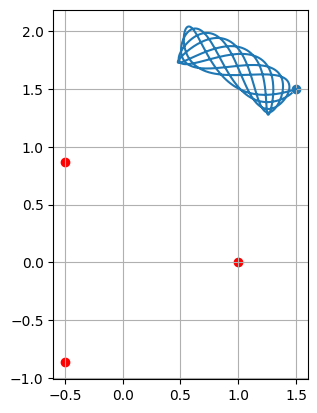

In [25]:
tend = 80
tt = np.linspace(0, tend, 1000)
xx0 = [1.5,1.5,0,0]
sol = solve_ivp(rhs_single, (0, tend), xx0, "RK45", t_eval=tt, rtol=1e-7, atol=1e-7)
# plt.plot(sol.t, sol.y[0], label="x1")
# plt.plot(sol.t, sol.y[1], label="x2")
# plt.legend()
# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter(sol.y[0][0], sol.y[1][0])
ax.set_aspect('equal', 'box')
ax.grid()
ax.scatter(*magnet_positions.T, color= "red")

In [17]:
def get_dominant_magnet(xx, colors):
    assert len(colors) == len(magnet_positions)
    distances = []
    n, m = xx.shape
    for _mag in magnet_positions:
        mag = np.zeros((m,2))
        mag[:] = _mag
        mag = mag.T
        distances.append([(mag[0]-xx[0])**2 + (mag[1]-xx[1])**2])
    indices = np.argmin(np.squeeze(np.array(distances)), axis=0)
    colorcode = np.zeros_like(indices, dtype=object)
    for i in range(len(colors)):
        colorcode[indices == i] = colors[i]
    return colorcode

In [18]:
limits = [[-2, 2], [-2, 2]]
num_interpolation_points = 200

mesh_index = []
for i in range(len(limits)):
    mesh_index.append(np.linspace(*limits[i], num_interpolation_points))
meshgrid = np.meshgrid(*mesh_index) # shape [(NIP, NIP, ..), (NIP, NIP, ..)]
points = np.vstack([x.ravel() for x in meshgrid]).T

In [22]:
import time
def simulate(xx, tend, dt=0.01, min_step = 100):
    step = 0
    n, m = xx.shape
    a_pre = np.zeros((2, m))
    a_cur = np.zeros((2, m))
    a_nex = np.zeros((2, m))
    times = np.array([0,0,0] ,dtype=float)
    # sol = []
    for t in np.linspace(0, tend, int(tend/dt)):
        step += 1
        t1 = time.time()
        # pos
        xx[0] += xx[2] * dt + 1/6 * (4*a_cur[0] - a_pre[0]) * dt**2
        xx[1] += xx[3] * dt + 1/6 * (4*a_cur[1] - a_pre[1]) * dt**2
        t2 = time.time()
        # acc
        a_nex = rhs(t, xx)[2:]
        t3 = time.time()
        # vel
        xx[2] += 1/6 * (2*a_nex[0] + 5*a_cur[0] - a_pre[0]) * dt
        xx[3] += 1/6 * (2*a_nex[1] + 5*a_cur[1] - a_pre[1]) * dt

        # propagate
        a_pre = a_cur
        a_cur = a_nex
        t4 = time.time()
        # sol.append(np.copy(xx))
        times += np.array([t2-t1, t3-t2, t4-t3])
        # sol.append(np.copy(xx))
        # if np.linalg.norm(xx[2:]) < 1e-2 and step > min_step:
        #     print(t)
        #     break
    # return np.array(sol), times
    return xx, times
dt = 0.01
tend = 20
xx0 = np.zeros((len(points), 4))
xx0[:,:2] = points
xx0 = xx0.T
xx0
sol, times = simulate(xx0, tend, dt)
times

array([ 1.14880204, 34.56939435,  1.26716161])

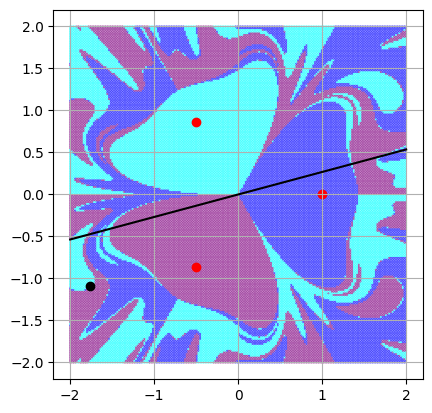

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ["blue", "cyan", "purple"]
colorcode = get_dominant_magnet(sol[:2], colors)
ax.scatter(*points.T, color=colorcode, s=0.1)
ax.set_aspect('equal', 'box')
ax.grid()
ax.scatter(*magnet_positions.T, color= "red")
ax.scatter(*points[9012], color="black")
# line
x = np.linspace(-2, 2, 100)
y = np.tan(1/12*np.pi)*x
plt.plot(x,y, color="black")

In [9]:
cyanidx = np.array(np.where(colorcode == "cyan"))[0]
np.where(np.abs(cyanidx[1:-1] - cyanidx[0:-2]) > 100)



(array([  74, 2298, 2342, 2379, 2421, 2470, 2515, 2562, 4144, 4178, 4196, 4215, 4235, 4259, 4283, 4312, 4340, 4366, 4391, 4415, 4439, 4464, 4494, 4524, 4553, 4644]),)

In [10]:
cyanidx[2562]

9012

In [11]:
colorcode[cyanidx[2562]+1]

'purple'

In [50]:
colorcode[9012], colorcode[9013]

('cyan', 'purple')

In [47]:
bb = np.array([1, np.tan(1/12*np.pi)])
# bb = np.array([1,0])
pp = np.array([1,1])
aa = np.array([0,0])
t0 = (pp-aa)@bb/(np.linalg.norm(bb))**2
ll = aa + t0*bb
pp_new = 2*ll-pp
pp_new

array([ 1.3660254, -0.3660254])

In [9]:
np.array([[-2], [0.5]]) * np.ones((2, 2000))

array([[-2. , -2. , -2. , ..., -2. , -2. , -2. ],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5]])

In [28]:
x[:,0]

array([-0.25602039, -0.12885006])

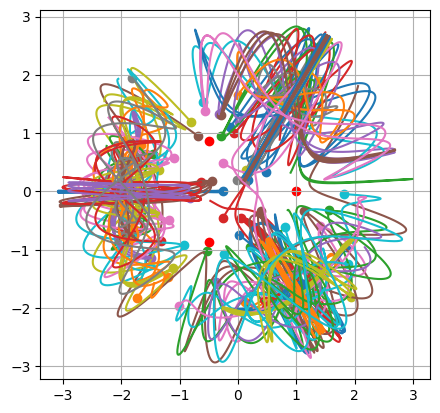

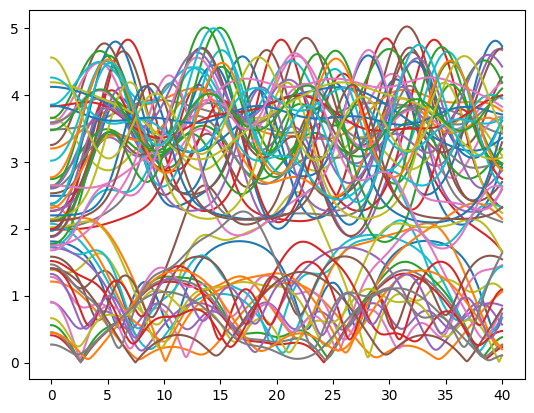

In [29]:

np.random.seed(2)
n = 70
x = (np.random.random(size=(2,n))-0.5)*4
w = np.zeros((2,n))
xx0 = np.array([*x, *w])
# xx0 = np.zeros((4,2))
# xx0[:2,0] = points[9012]
# xx0[:2,1] = points[9013]
# xx0[:2,0] = pp
# xx0[:2,1] = pp_new

tend = 40
tt = np.linspace(0, tend, 2000)
fig = plt.figure()
ax = fig.add_subplot(111)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
point = np.array([-2, 0.5])
for x0 in xx0.T:
    sol = solve_ivp(rhs_single, (0, tend), x0, "RK45", t_eval=tt, rtol=1e-7, atol=1e-7)
    ax.plot(sol.y[0], sol.y[1])
    ax.scatter(sol.y[0][0], sol.y[1][0])
    dist = np.sqrt((sol.y[0]-point[0])**2 + (sol.y[1]-point[1])**2)
    ax2.plot(sol.t, dist)
ax.set_aspect('equal', 'box')
ax.grid()
ax.scatter(*magnet_positions.T, color= "red")
# x = np.linspace(-2, 2, 100)
# y = np.tan(1/12*np.pi)*x
# ax.plot(x,y, color="black")

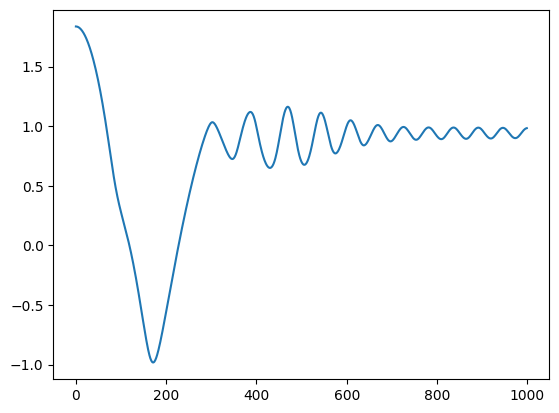

In [11]:
plt.plot(sol.y[0]*np.cos(1/12*np.pi)+sol.y[1]*np.sin(1/12*np.pi))

In [8]:
np.cos(1/12*np.pi)

0.9659258262890683

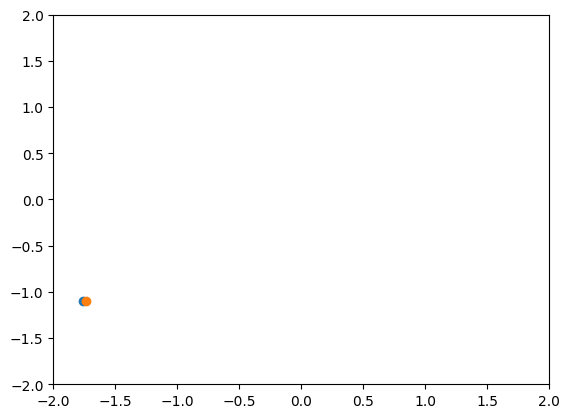

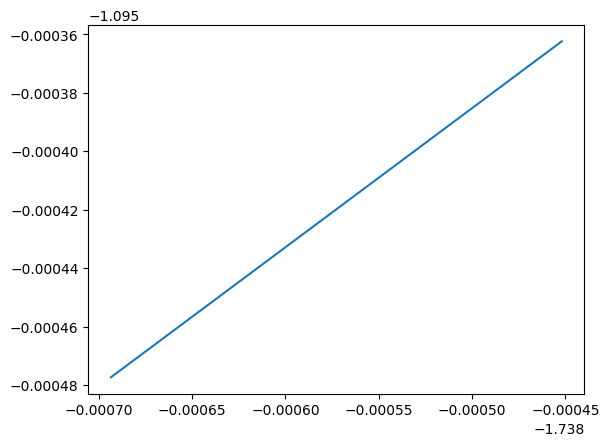

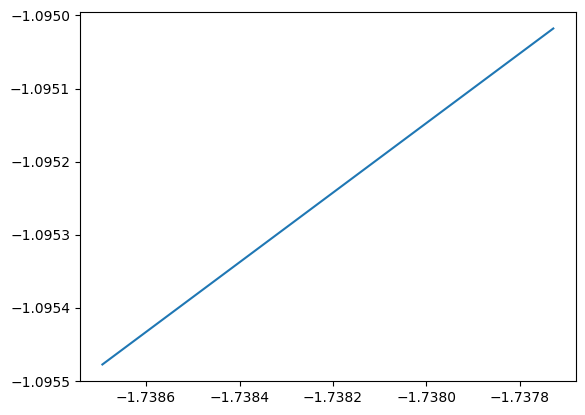

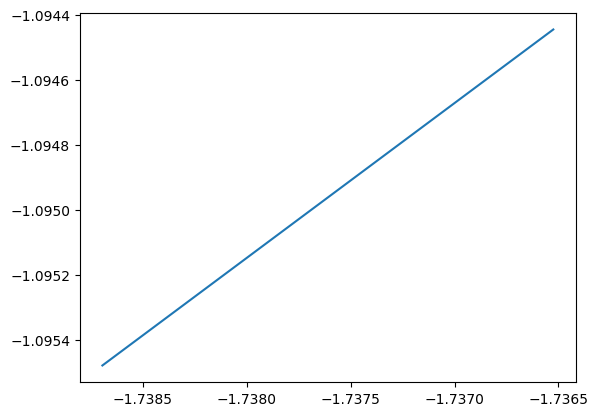

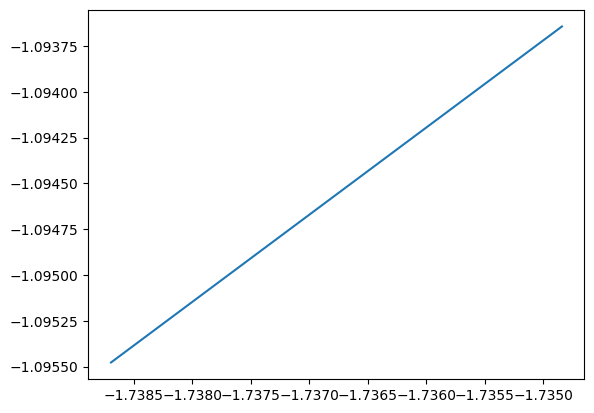

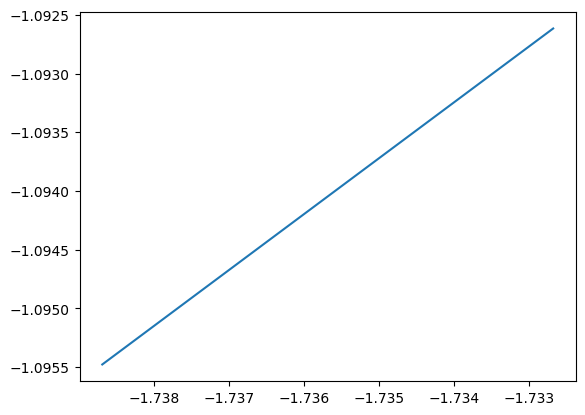

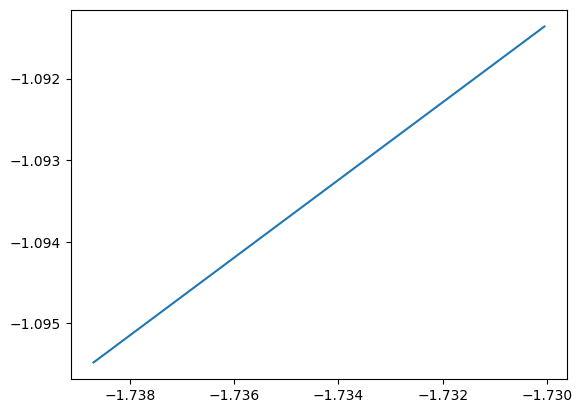

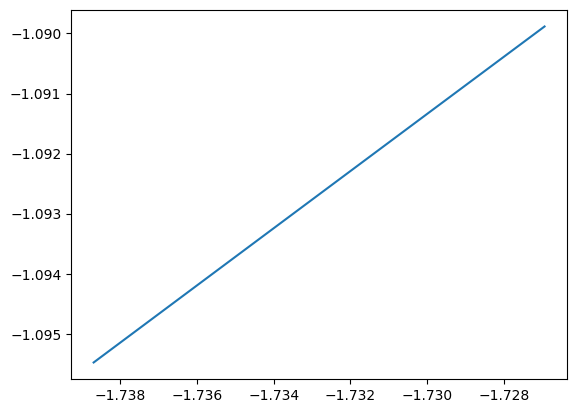

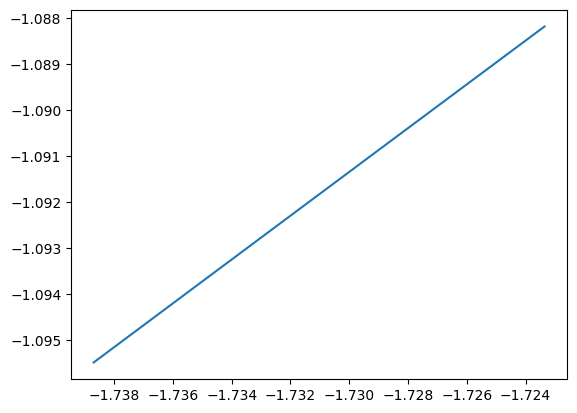

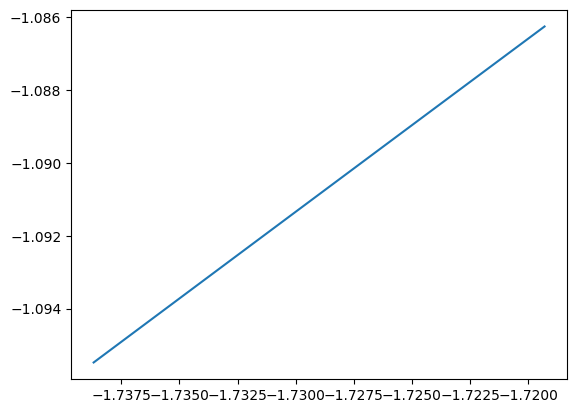

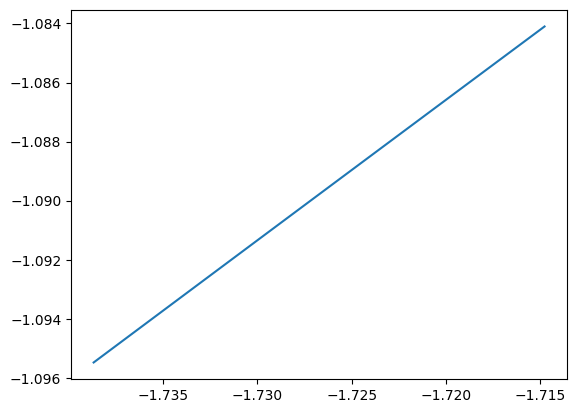

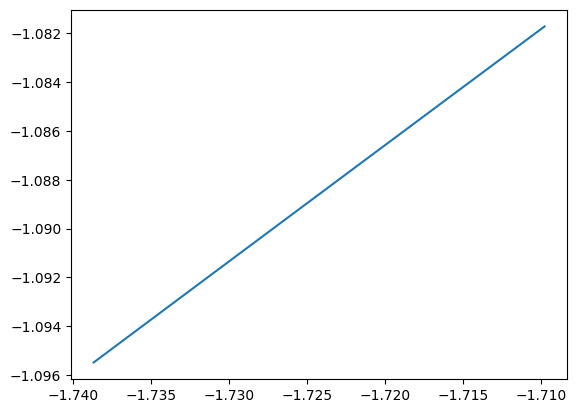

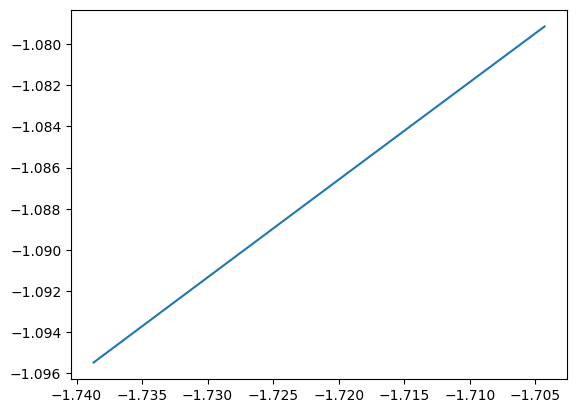

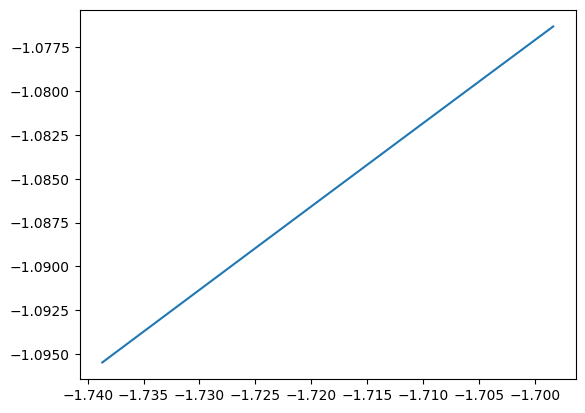

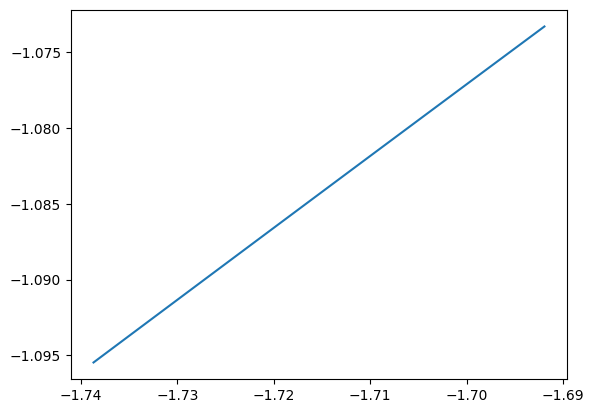

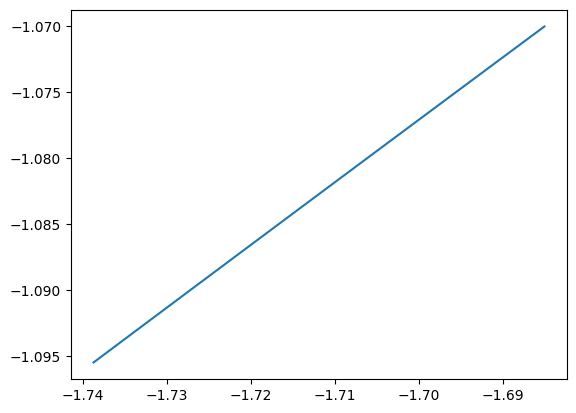

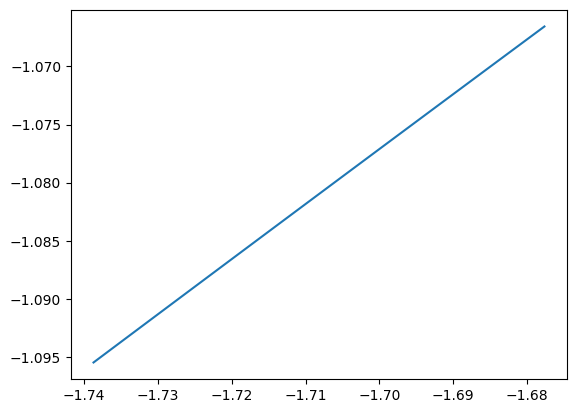

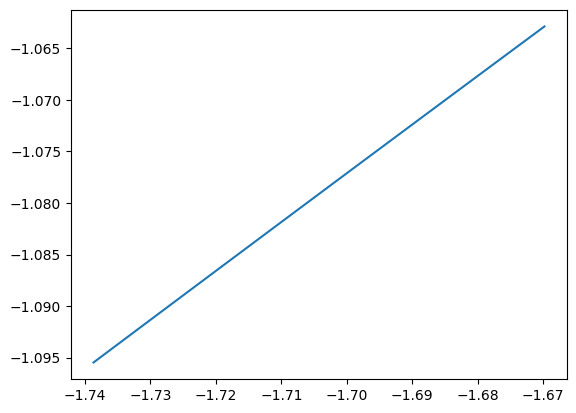

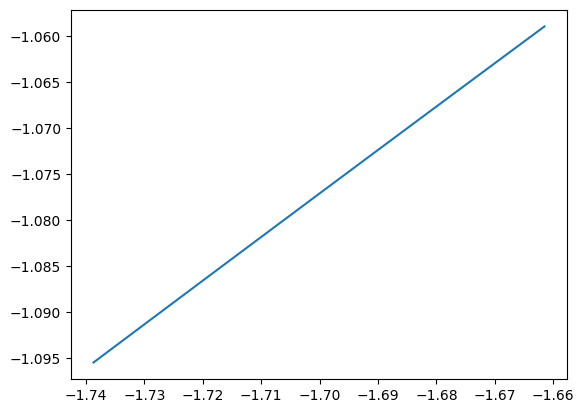

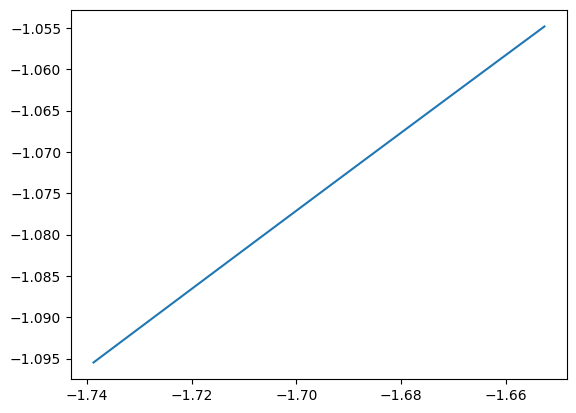

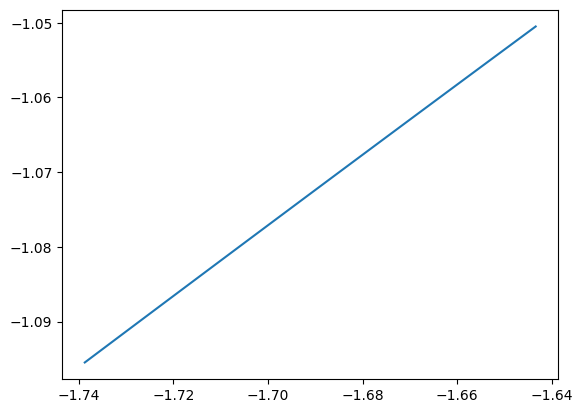

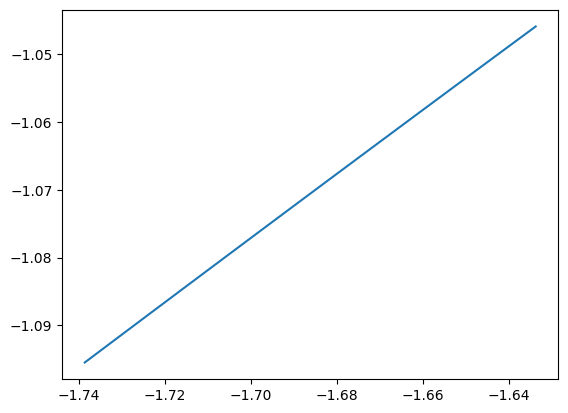

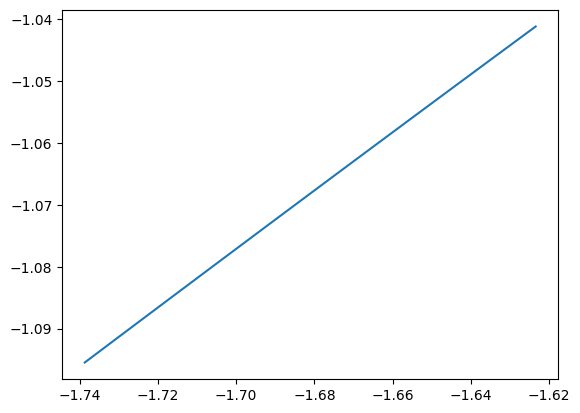

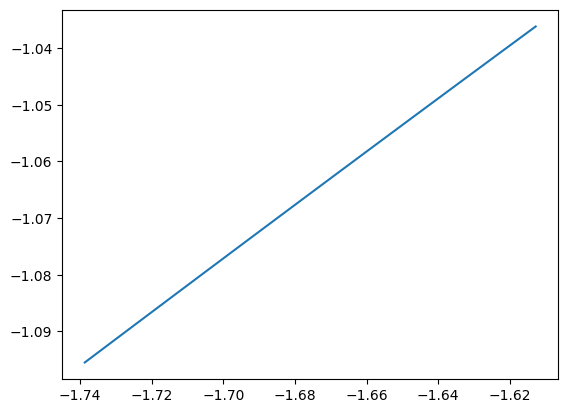

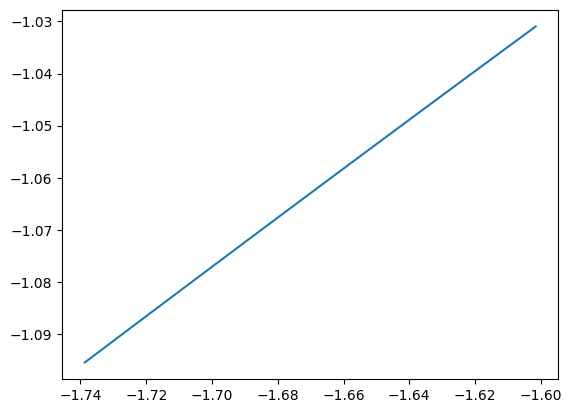

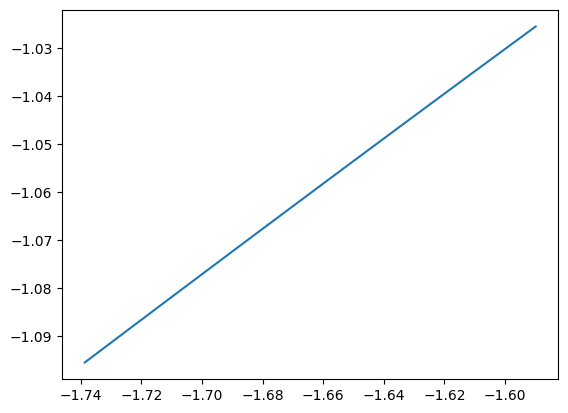

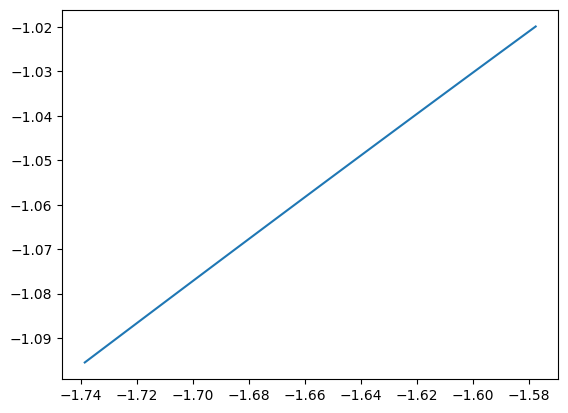

KeyboardInterrupt: 

In [16]:
xx0 = np.zeros((4,2))
xx0[:2,0] = points[9012]
xx0[:2,1] = points[9013]

tend = 20
tt = np.linspace(0, tend, 1000)
fig = plt.figure()
ax = fig.add_subplot(111)
solutions = []
for x0 in xx0.T:
    sol = solve_ivp(rhs_single, (0, tend), x0, "RK45", t_eval=tt, rtol=1e-7, atol=1e-7)
    solutions.append(sol)
x = []
y = []
plt.xlim(-2,2)
plt.ylim(-2,2)
ax.scatter(solutions[0].y[0][0], solutions[0].y[1][0])
ax.scatter(solutions[1].y[0][0], solutions[1].y[1][0])
for i in range(len(solutions[0].t)):
    # for sol in solutions:
    x.append(sol.y[0, i])
    y.append(sol.y[1, i])
    plt.plot(x, y)
    plt.pause(0.01)
    plt.show()

ax.set_aspect('equal', 'box')
ax.grid()
ax.scatter(*magnet_positions.T, color= "red")

In [8]:
for pos in magnet_positions:
    print(np.linalg.norm(pos))


1.0
1.0
1.0
